# Part B: Regression Problem

This assignment uses the data from the Graduate Admissions Predication \[2\]. The dataset contains several parameters like GRE score (out of 340), TOEFL score (out of 120), university Rating (out of 5), strengths of Statement of Purpose and Letter of Recommendation (out of 5), undergraduate GPA (out of 10), research experience (either 0 or 1), that are considered important during the application for Master Programs. The predicted parameter is the chance of getting an admit (ranging from 0 to 1). You can obtain the data from: https://www.kaggle.com/mohansacharya/graduate-admissions or from file ‘admission_predict.csv’.

Each data sample is a row of 9 values: 1 serial number (ignore), 7 input attributes and the probability of getting an admit as targets. Divide the dataset at 70:30 ratio for training and testing.

\[2\] Mohan S Acharya, Asfia Armaan, Aneeta S Antony: A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019.

In [1]:
# import relevant libraries
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import random

In [2]:
# configurations
seed = 0  # for reproducible results when randomness is introduced
random.seed(seed)
tf.random.set_seed(seed)  # since shuffle=True in model.fit()

In [3]:
# load data
dataframe = pd.read_csv('data/admission_predict.csv')
dataframe.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [55]:
print(f'number of data points: {len(dataframe)}')

number of data points: 400


In [4]:
# ignore serial number like what question asked
dataframe = dataframe.drop(columns='Serial No.')
dataframe.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
# show basic information of data
dataframe.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


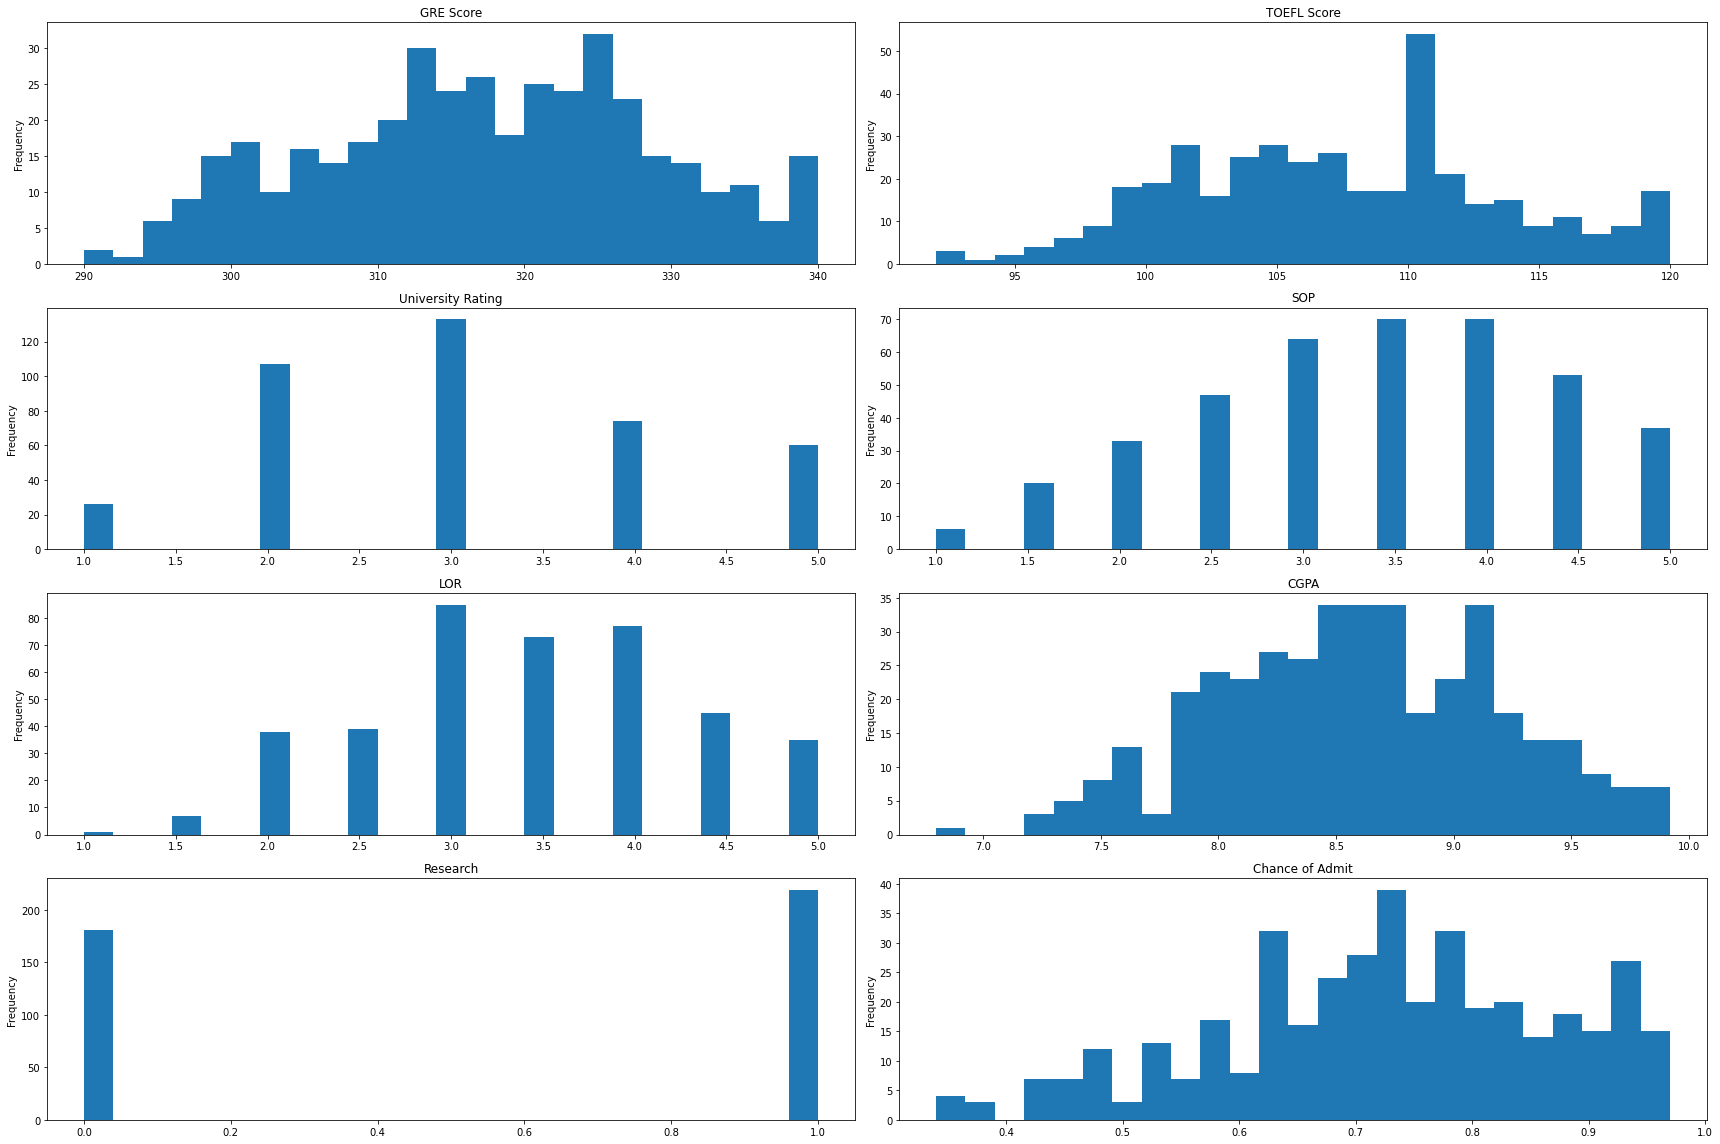

In [6]:
# show distribution for each feature
figure, axes = plt.subplots(nrows=4, ncols=2, figsize=(24, 16))

for index, column in enumerate(dataframe.columns):
    feature = dataframe[column]  # and target (admission probability)

    row_num = index // 2
    col_num = index % 2

    feature.plot.hist(bins=25, ax=axes[row_num, col_num])
    axes[row_num, col_num].set_title(column)

figure.tight_layout()

plt.savefig('output/b.png')

del figure

Looks like almost all features, as well as the target variable, follow normal distribution approximately. The exception is the Research feature, which is binary.

In [7]:
# separate features from target
target = dataframe['Chance of Admit']
features = dataframe.drop(columns='Chance of Admit')

del dataframe

In [8]:
target.head()

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
Name: Chance of Admit, dtype: float64

In [9]:
features.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [10]:
# scale the features like in assignment 1 part a (data approximately normal)
# minus mean, divide by standard deviation
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features)

del scaler

In [11]:
features.head()

,0,1,2,3,4,5,6
0,1.762107,1.746971,0.798829,1.093864,1.167321,1.764818,0.909112
1,0.627656,-0.067635,0.798829,0.596653,1.167321,0.455151,0.909112
2,-0.070467,-0.562528,-0.076600,-0.397769,0.052933,-1.005631,0.909112
3,0.453126,0.427257,-0.076600,0.099442,-1.061454,0.119339,0.909112
4,-0.244998,-0.727492,-0.952029,-1.392191,-0.504260,-0.653029,-1.099975


In [12]:
# Divide the dataset at 70:30 ratio for training and testing.
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=seed,
)

1. Design a 3-layer feedforward neural network consists of an input layer, a hidden-layer of 10 neurons having ReLU activation functions, and a linear output layer. Use mini-batch gradient descent with a batch size = 8, L<sub>2</sub> regularization at weight decay parameter β = 10<sup>-3</sup> and a learning rate α = 10<sup>-3</sup> to train the network.

In [13]:
# input layer params
num_features = len(features.columns)

# hidden layer params
num_hidden_neurons = 10
hidden_activation = 'relu'
weight_decay_parameter = 10**-3

# output layer params
num_classes = 1  # probability of admission only
output_activation = 'linear'

del features
del target

In [14]:
# define function to generate a model for usage later
def get_neural_network(
    num_features: int,
    num_hidden_layers: int = 1,
    num_hidden_neurons: int = 10,
    dropout_rate: float = 0,
) -> tf.keras.Sequential:
    '''
    Generates a fully-connected neural network of at least 3 layers.
        layer 1 - input layer
        layer 2 - hidden layer
        ...
        layer n - output layer (linear)
    
    :params:
    - num_features (int): number of features for the model to work with
    - num_hidden_layers (int): number of hidden layers - must be at least 1 (default: 1)
    - dropout_rate (float): the frequency at which the Dropout layer randomly sets input units to 0 (default: 0)
    dropout_rate == 0 --> no dropout
    
    :return:
    - (tf.keras.Sequential)
    '''
    if num_features < 1:
        raise ValueError('There must be at least 1 feature for the model to train on.')
        
    if num_hidden_layers < 1:
        raise ValueError('There must be at least 1 hidden layer in the model.')
        
    if num_hidden_neurons < 1:
        raise ValueError('There must be at least 1 neuron in the hidden layer.')
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(
        input_shape=num_features,
    ))
    
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(
            num_hidden_neurons,
            activation=hidden_activation,
            kernel_regularizer=tf.keras.regularizers.l2(l=weight_decay_parameter),
        ))
        
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(
                dropout_rate,
                seed=seed,
            ))

    model.add(tf.keras.layers.Dense(
        num_classes,
        activation=output_activation,
    ))

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['mse'],
    )

    return model

In [15]:
# training params
learning_rate = 10**-3
batch_size = 8
num_epochs_per_step = 50  # 1 epoch per step is too unstable, so take average over multiple epochs

In [16]:
# define train function for usage later
def train(
    model: tf.keras.Sequential,
    train_features: pd.DataFrame,
    train_labels: pd.Series,
    test_features: pd.DataFrame,
    test_labels: pd.Series,
) -> tuple:
    '''
    Train a model using the given data.
    
    :params:
    - model (tf.keras.Sequential): the model to be trained
    - train_features (pd.DataFrame): features for model to train on
    - train_labels (pd.Series): labels for model to train on
    - test_features (pd.DataFrame): features for model to use for validation and evaluation
    - test_labels (pd.Series): labels for model to use for validation and evaluation
    
    :return:
    tuple consisting of
    - model that has been trained
    - training history (dict with keys: 'loss', 'val_loss', 'mse', 'val_mse')
    - evaluation results (dict with keys: 'loss', 'mse', 'num_epochs')
    '''
    previous_average_mse = 3
    current_average_mse = 2
    next_average_mse = 1
    
    stop_early = False

    num_epochs = 0  # count actual total number of training epochs
    history = {  # fit multiple times, so need to store history
        'loss': [],
        'val_loss': [],
        'mse': [],
        'val_mse': [],
    }

    while not stop_early:   
        train_history = model.fit(
            x=train_features,
            y=train_labels,
            batch_size=batch_size,
            epochs=num_epochs_per_step,
            verbose=0,  # not showing training details
            validation_data=(test_features, test_labels),
            shuffle=True,
        )

        num_epochs += num_epochs_per_step

        for metric, values in train_history.history.items():
            history[metric] += values

        previous_average_mse, current_average_mse = current_average_mse, next_average_mse
        next_average_mse = sum(train_history.history['val_mse']) / num_epochs_per_step
        
        stop_early = current_average_mse < previous_average_mse and \
            current_average_mse < next_average_mse  # early stopping at minimum test error
        
        # final model overfits a little since it stops 50 epochs after minimum test error

    results = model.evaluate(
        test_features,
        test_labels,
        batch_size=batch_size,
        return_dict=True,
    )
    results['num_epochs'] = num_epochs
    
    return model, history, results

In [17]:
# define function to print results after training a model
def print_results(results: dict):
    '''
    Print evaluation scores and number of epochs.
    Loss and MSE values are printed to 4 decimal places.
    
    :params:
    - results (dict): holds evaluation results - keys: 'loss', 'mse', 'num_epochs'
    '''
    loss = results['loss']
    accuracy = results['mse']
    num_epochs = results['num_epochs']
    
    print(f'test loss: {loss:.4f}, test mse: {accuracy:.4f}')
    print(f'number of epochs to reach minimum test error: {num_epochs}')

In [18]:
# define function to plot loss and MSE curves for usage later
def plot_loss_accuracy_curves(num_epochs: int, history: dict, image_path: str = None):
    '''
    Plots loss curve and MSE curve side-by-side.
    
    :params:
    - total_num_epochs (int): total number of epochs for model to get minimal test error
    - history (dict): history of loss and MSE values at each epoch - keys: 'loss', 'val_loss', 'mse', 'val_mse'
    - image_path (str): save figure as image to this file path (default: None / no save)
    '''
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title('loss')
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
    loss_axis.legend()

    accuracy_axis.set_title('mse')
    accuracy_axis.plot(range(num_epochs), history['mse'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_mse'], label='test')
    accuracy_axis.legend()

    if image_path is not None:
        plt.savefig(image_path)

a) Use the train dataset to train the model and plot both the train and test errors against epochs.

b) State the approximate number of epochs where the test error is minimum and use it to stop training.

In [19]:
# get model
model = get_neural_network(num_features)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [20]:
# train model
model, history, results = train(model, train_features, train_labels, test_features, test_labels)

15/15 [==============================] - 0s 1ms/step - loss: 0.0081 - mse: 0.0053


In [21]:
# check evaluation scores
print_results(results)

test loss: 0.0081, test mse: 0.0053
number of epochs to reach minimum test error: 6550


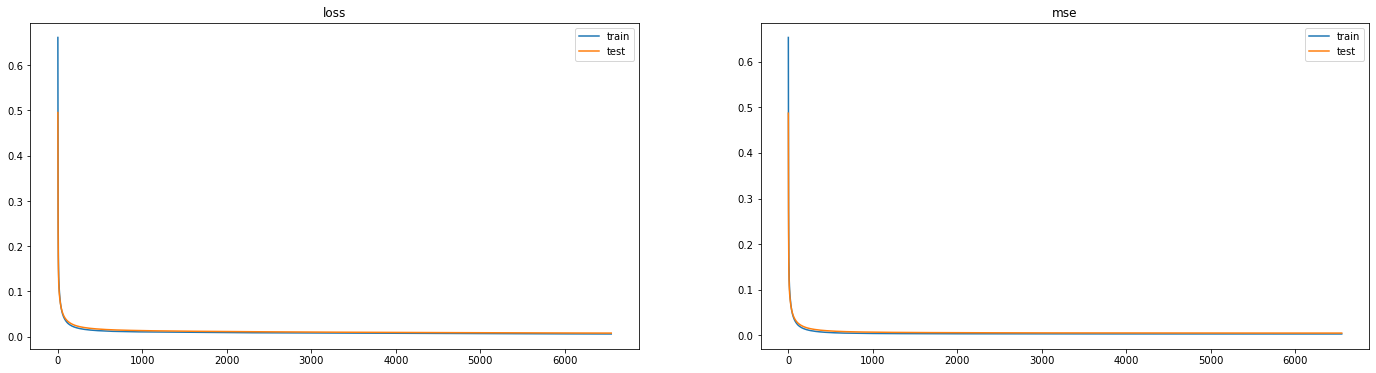

In [22]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_1a.png')

del results
del history

c) Plot the predicted values and target values for any 50 test samples.

In [23]:
test_features.head()

,0,1,2,3,4,5,6
132,-0.681325,-0.397564,1.674257,0.099442,0.052933,-0.065357,-1.099975
309,-0.768590,0.427257,0.798829,0.099442,-0.504260,0.001805,-1.099975
341,0.802187,0.427257,-0.076600,0.099442,0.052933,0.270455,0.909112
196,-0.943121,-0.397564,-0.952029,-0.397769,-1.061454,-0.569076,-1.099975
246,-0.070467,-0.397564,-0.076600,-0.397769,0.052933,0.220083,-1.099975


In [24]:
test_labels.head()

132    0.71
309    0.70
341    0.79
196    0.73
246    0.72
Name: Chance of Admit, dtype: float64

In [25]:
# get sample indices
sample_indices = random.sample(range(len(test_labels)), 50)

In [26]:
# get sample of the test features
test_features_sample = test_features.iloc[sample_indices]
test_features_sample.head()

,0,1,2,3,4,5,6
153,0.627656,-0.397564,-0.076600,-0.397769,0.610127,0.253664,-1.099975
233,-1.117652,-1.222385,-0.952029,-0.894980,0.052933,-0.888097,-1.099975
390,-0.244998,-0.892456,-0.952029,-1.392191,-1.061454,-0.602657,-1.099975
21,0.714922,1.087114,0.798829,-0.397769,-1.618648,-0.334007,-1.099975
171,1.500310,1.582006,1.674257,0.596653,1.167321,0.790963,0.909112


In [27]:
# get sample of the test labels
test_labels_sample = test_labels.iloc[sample_indices]
test_labels_sample.head()

153    0.79
233    0.64
390    0.64
21     0.70
171    0.89
Name: Chance of Admit, dtype: float64

In [28]:
predictions = model.predict(test_features_sample, batch_size=batch_size)

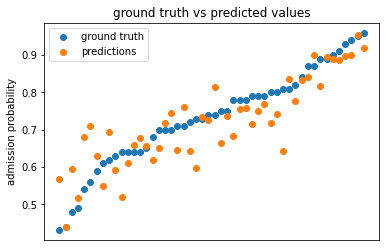

In [29]:
# process values for plotting
test_label_list = test_labels_sample.tolist()
prediction_list = predictions.flatten().tolist()

# sort by ground truth values first to see if there is any pattern / trend
sorted_values = sorted(zip(test_label_list, prediction_list))

sorted_test_labels = []
sorted_predictions = []

for test_label, prediction in sorted_values:
    sorted_test_labels.append(test_label)
    sorted_predictions.append(prediction)
    
plt.title('ground truth vs predicted values')
plt.scatter(range(len(sorted_values)), sorted_test_labels, label='ground truth')
plt.scatter(range(len(sorted_values)), sorted_predictions, label='predictions')
plt.legend()
plt.xticks([])  # disable x-ticks because it is not meaningful here
plt.ylabel('admission probability')

plt.savefig('output/b_1c.png')

Looks like the model tend to underestimate the probability of admission. Also, the model seems to predict the admission probability more accurately (shorter distance between predicted and ground truth values)when admission probability is high.

2. Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. Start by removing one input feature that causes the minimum drop (or maximum improvement) in performance. Repeat the procedure recursively on the reduced input set until the optimal number of input features is reached. Remove the features one at a time. Compare the accuracy of the model with all input features, with models using 6 input features and 5 input features selected using RFE. Comment on the observations.

In [30]:
# use RFE with cross validation to get optimal number of features

# reference: https://stackoverflow.com/a/50200699/9171260
# linear regression is probably most related

rfecv = RFECV(LinearRegression(), step=1)  # remove features one at a time
rfecv.fit(train_features, train_labels)
print()  # no need to print anything after doing RFECV

In [31]:
optimal_num_features = int(rfecv.n_features_)
print(f'optimal number of input features: {optimal_num_features}')

optimal number of input features: 5


In [32]:
optimal_indices = rfecv.get_support(indices=True)
print(f'optimal features indices: {optimal_indices}')

optimal features indices: [0 1 4 5 6]


Looks like University Rating and SOP are less important factors when considering applicant for Master programs.

In [33]:
# get optimal features
optimal_train_features = train_features[optimal_indices]
optimal_test_features = test_features[optimal_indices]

In [34]:
# get model
model = get_neural_network(optimal_num_features)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [35]:
# train model
model, history, results = train(
    model,
    optimal_train_features,
    train_labels,
    optimal_test_features,
    test_labels,
)

del model

15/15 [==============================] - 0s 1ms/step - loss: 0.0065 - mse: 0.0047


In [36]:
# check evaluation scores
print_results(results)

test loss: 0.0065, test mse: 0.0047
number of epochs to reach minimum test error: 8950


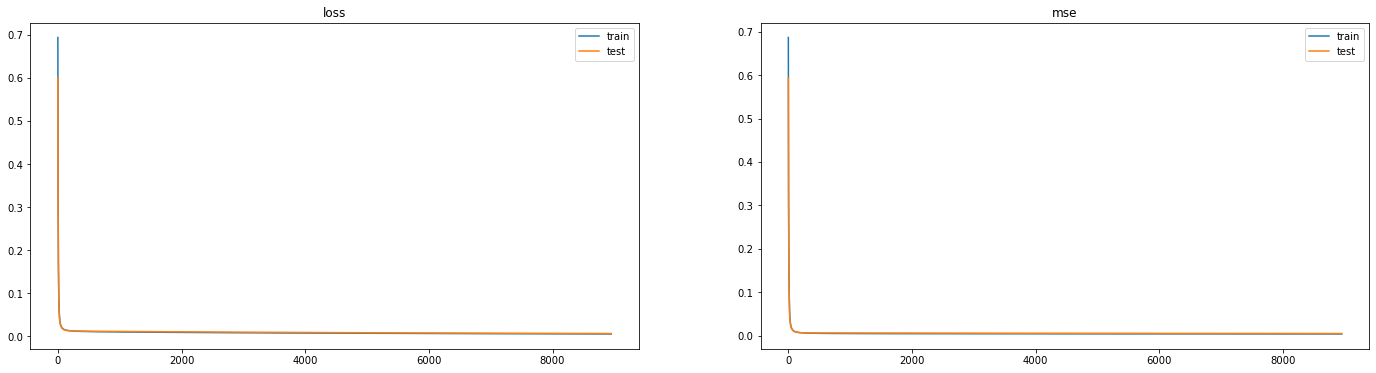

In [37]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_2_1.png')

del results
del history

In [53]:
# do the same thing for 6 features
rfecv = RFECV(LinearRegression(), step=1, min_features_to_select=6)
rfecv.fit(train_features, train_labels)

selected_indices = rfecv.get_support(indices=True)
print(f'selected features indices: {selected_indices}')

selected features indices: [0 1 3 4 5 6]


In [39]:
# get selected features
selected_train_features = train_features[selected_indices]
selected_test_features = test_features[selected_indices]

In [40]:
# get model
model = get_neural_network(num_features=6)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [41]:
# train model
model, history, results = train(
    model,
    selected_train_features,
    train_labels,
    selected_test_features,
    test_labels,
)

del model

15/15 [==============================] - 0s 1ms/step - loss: 0.0060 - mse: 0.0048


In [42]:
# check evaluation scores
print_results(results)

test loss: 0.0060, test mse: 0.0048
number of epochs to reach minimum test error: 12300


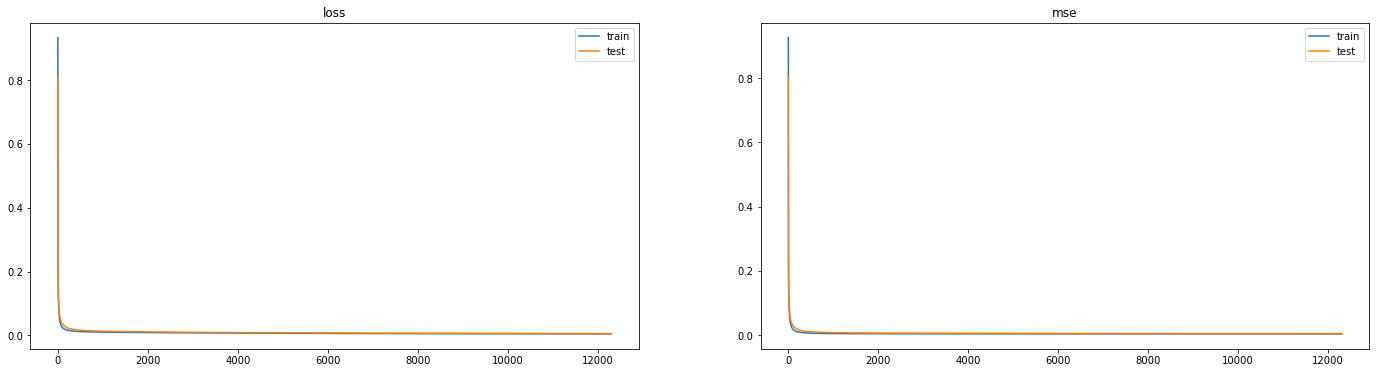

In [43]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_2_2.png')

del results
del history

### Comparison of training on 5, 6, or 7 (all) features

\\|5 features (optimal)| 6 features| 7 (all) features
-|-|-|-
loss|0.0065|0.0060|0.0081
mean squared error|0.0047|0.0048|0.0053
number of trainable parameters|71|81|91
number of epochs|8950|12300|6550

3. Design a four-layer neural network and a five-layer neural network, with the hidden layers having 50 neurons each. Use a learning rate of 10<sup>-3</sup> for all layers and optimal feature set selected in part (3).  
Introduce dropouts (with a keep probability of 0.8) to the layers and report the accuracies. Compare the performances of all the networks (with and without dropouts) with each other and with the 3-layer network.

In [44]:
# params and configs
num_hidden_neurons = 50
# no change in learning_rate (10**-3)
dropout_keep_probability = 0.8

In [45]:
# get model (4 layers, no dropout)
model = get_neural_network(
    optimal_num_features,
    num_hidden_layers=2,
    num_hidden_neurons=num_hidden_neurons,
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________


15/15 [==============================] - 0s 1ms/step - loss: 0.0384 - mse: 0.0050
test loss: 0.0384, test mse: 0.0050
number of epochs to reach minimum test error: 4100


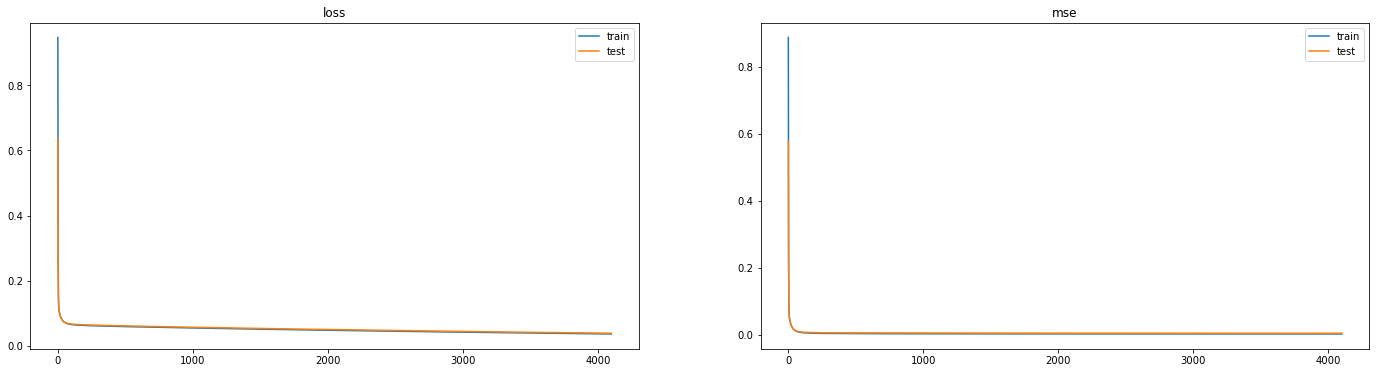

In [46]:
# train model
model, history, results = train(
    model,
    optimal_train_features,
    train_labels,
    optimal_test_features,
    test_labels,
)

del model

# check evaluation scores
print_results(results)

plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_3_1.png')

del results
del history

In [47]:
# get model (4 layers, dropout)
model = get_neural_network(
    optimal_num_features,
    num_hidden_layers=2,
    num_hidden_neurons=num_hidden_neurons,
    dropout_rate=(1 - dropout_keep_probability),
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                300       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________


15/15 [==============================] - 0s 1ms/step - loss: 0.0556 - mse: 0.0051
test loss: 0.0556, test mse: 0.0051
number of epochs to reach minimum test error: 750


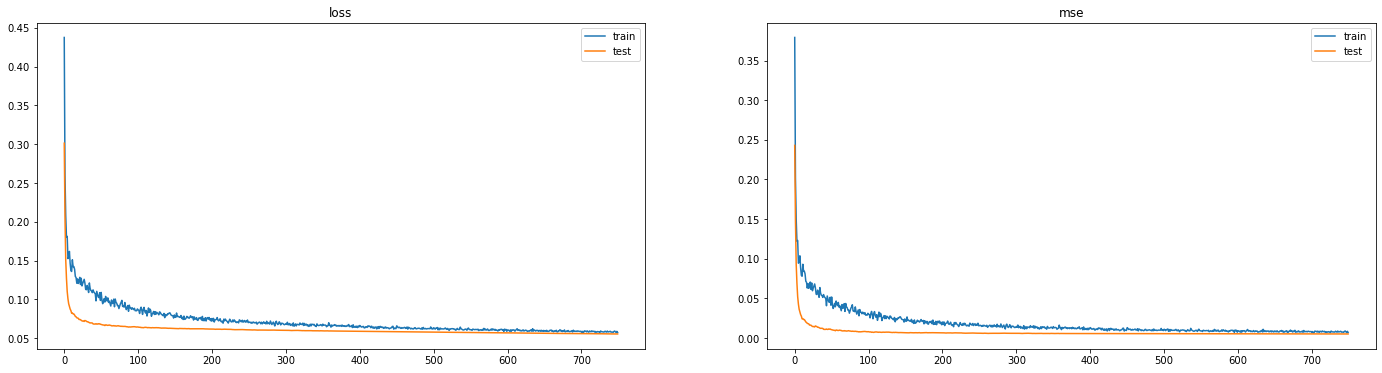

In [48]:
# train model
model, history, results = train(
    model,
    optimal_train_features,
    train_labels,
    optimal_test_features,
    test_labels,
)

del model

# check evaluation scores
print_results(results)

plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_3_2.png')

del results
del history

In [49]:
# get model (5 layers, no dropout)
model = get_neural_network(
    optimal_num_features,
    num_hidden_layers=3,
    num_hidden_neurons=num_hidden_neurons,
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                300       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________


15/15 [==============================] - 0s 1ms/step - loss: 0.0221 - mse: 0.0048
test loss: 0.0221, test mse: 0.0048
number of epochs to reach minimum test error: 13850


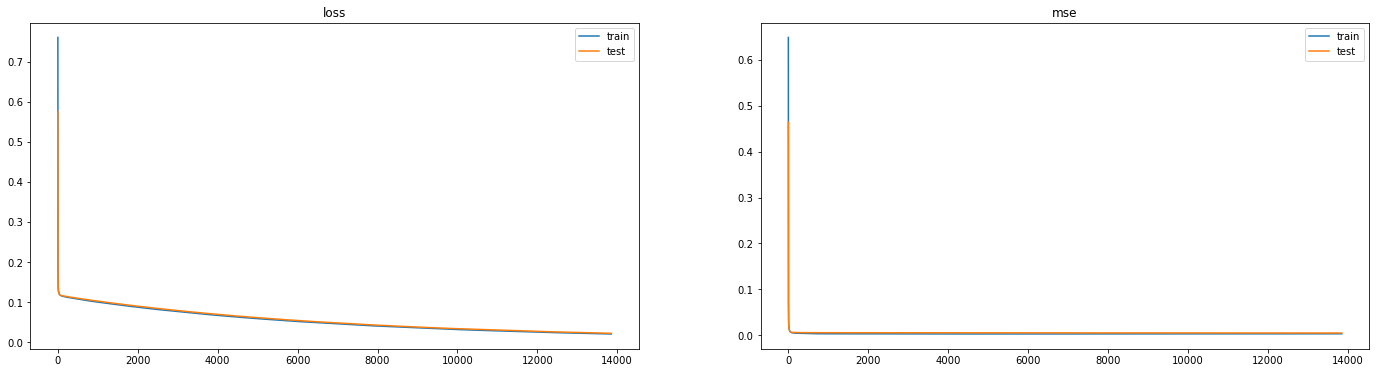

In [50]:
# train model
model, history, results = train(
    model,
    optimal_train_features,
    train_labels,
    optimal_test_features,
    test_labels,
)

del model

# check evaluation scores
print_results(results)

plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_3_3.png')

del results
del history

In [51]:
# get model (5 layers, dropout)
model = get_neural_network(
    optimal_num_features,
    num_hidden_layers=3,
    num_hidden_neurons=num_hidden_neurons,
    dropout_rate=(1 - dropout_keep_probability),
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

15/15 [==============================] - 0s 1ms/step - loss: 0.0932 - mse: 0.0059
test loss: 0.0932, test mse: 0.0059
number of epochs to reach minimum test error: 1450


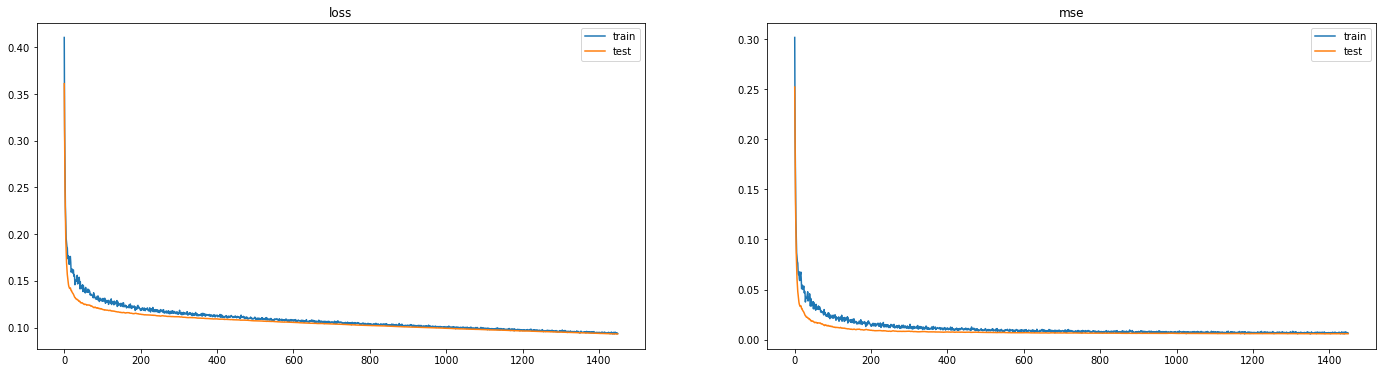

In [52]:
# train model
model, history, results = train(
    model,
    optimal_train_features,
    train_labels,
    optimal_test_features,
    test_labels,
)

del model

# check evaluation scores
print_results(results)

plot_loss_accuracy_curves(results['num_epochs'], history, 'output/b_3_4.png')

del results
del history

## Comparisons

### 4 layers, no dropout vs dropout

\\|no dropout|dropout
-|-|-
loss|0.0384|0.0556
mean squared error|0.0050|0.0051
number of trainable params|2901|2901
number of epochs|4100|750

### 5 layers, no dropout vs dropout

\\|no dropout|dropout
-|-|-
loss|0.0221|0.0932
mean squared error|0.0048|0.0059
number of trainable params|5451|5451
number of epochs|13850|1450

### no dropout, 3 layers (10 neurons) vs 4 layers (50 neurons) vs 5 layers (50 neurons)

\\|3 layers|4 layers|5 layers
-|-|-|-
loss|0.0065|0.0384|0.0221
mean squared error|0.0047|0.0050|0.0048
number of trainable params|71|2901|5451
number of epochs|8950|4100|13850

### dropout, 4 layers vs 5 layers

\\|4 layers|5 layers
-|-|-
loss|0.0556|0.0932
mean squared error|0.0051|0.0059
number of trainable params|2901|5451
number of epochs|750|1450